<a href="https://colab.research.google.com/github/Victor18Azevedo/desafio-dio-banco/blob/master/Projeto_de_Disciplina_de_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle 
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

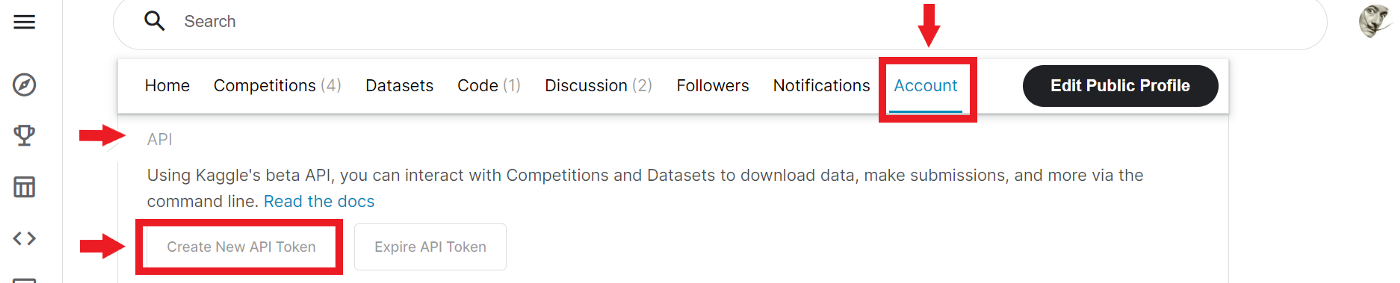

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

## Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json 

In [ ]:
#Celula 1
!pip install -q kaggle
!rm -rf kaggle.json
from google.colab import files

files.upload()

Crie a pasta .kaggle

In [ ]:
#Celula 2
!rm -rf .kaggle
!mkdir .kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 .kaggle/kaggle.json

Baixe o dataset

In [ ]:
#Celula 3
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

 97% 181M/187M [00:03<00:00, 55.6MB/s]
100% 187M/187M [00:03<00:00, 61.8MB/s]


# Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [ ]:
#Celula 4
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [ ]:
#Celula 5
!pip install -U spacy > /dev/null
!python -m spacy download pt_core_news_lg

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568.2 MB 6.8 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [ ]:
#Celula 6
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('rslp')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## Carregar os módulos usados ao longo desse notebook

In [ ]:
!pip install pyldavis &> /dev/null

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


##Compreendendo o Dataset

In [ ]:
df.sample(10)

,title,text,date,category,subcategory,link
104516,Av. Paulista deve permanecer fechada para veíc...,"UMA PAULISTA TRANQUILA Criar uma ""ilha de tra...",2015-07-11,opiniao,NaN,http://www1.folha.uol.com.br/opiniao/2015/11/1...
86145,"No teatro, Tiago Abravanel 'ganha em um mês o ...","Tiago Abravanel, 28, toma um impulso e sai cor...",2016-02-21,colunas,monicabergamo,http://www1.folha.uol.com.br/colunas/monicaber...
94290,Deputado questiona declaração de presidente de...,Onde está a credibilidade do petista Vicente A...,2016-01-01,paineldoleitor,NaN,http://www1.folha.uol.com.br/paineldoleitor/20...
58598,Saúde remediada,"A proposta do ministro da Saúde, Ricardo Barro...",2016-07-28,opiniao,NaN,http://www1.folha.uol.com.br/opiniao/2016/07/1...
126552,Orquestra vence programa ambicioso com dificul...,Imagine um time formado por jovens jogadores –...,2015-07-14,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2015/07...
138263,Ensaio dos anos 1940 retrata e idealiza rotina...,"Um médico que ganha pouco, atua numa região in...",2015-05-14,seminariosfolha,NaN,http://www1.folha.uol.com.br/seminariosfolha/2...
136536,O governo da mentira,A Mentira Original contamina o governo de Dilm...,2015-05-23,colunas,demetriomagnoli,http://www1.folha.uol.com.br/colunas/demetriom...
72548,Quadrinhos,NaN,2016-06-05,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2016/05...
117377,"Vizinhos italianos criam rede social própria, ...","Quando Laurell Boyers, 34, e seu marido, Feder...",2015-08-31,tec,NaN,http://www1.folha.uol.com.br/tec/2015/08/16752...
155393,Ferrer derruba algoz de Feijão e está na final...,O espanhol David Ferrer contou com apoio da to...,2015-02-21,esporte,NaN,http://www1.folha.uol.com.br/esporte/2015/02/1...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167053 entries, 0 to 167052
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        167053 non-null  object
 1   text         166288 non-null  object
 2   date         167053 non-null  object
 3   category     167053 non-null  object
 4   subcategory  29635 non-null   object
 5   link         167053 non-null  object
dtypes: object(6)
memory usage: 7.6+ MB


## Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [ ]:
#Celula 10
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
# Create a dataframe named news_2016
news_2016 = df.query('20151231 < date < 20170101').reset_index(drop = True)
news_2016 = news_2016[news_2016.category == 'mercado']
news_2016

,title,text,date,category,subcategory,link
27,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
58,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
65,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
68,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
69,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
...,...,...,...,...,...,...
60100,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
60115,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
60121,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
60130,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...


##Compreendendo os dados de 2016 e Mercado

In [ ]:
news_2016.date.value_counts().sort_index()

2016-01-01    11
2016-01-02    38
2016-01-03    24
2016-01-04    21
2016-01-05    10
              ..
2016-12-27    23
2016-12-28    11
2016-12-29    26
2016-12-30    16
2016-12-31     5
Name: date, Length: 366, dtype: int64

In [ ]:
news_2016.category.value_counts()

mercado    7943
Name: category, dtype: int64

In [ ]:
#Celula 13
news_2016.text.value_counts()

A Folha, em parceria com a faculdade ESPM, realiza na terça (7), às 15h, nova rodada do Arena do Marketing, evento voltado a debater o universo da publicidade e da propaganda no Brasil. O programa terá transmissão ao vivo pelo site da "TV Folha".  As medidas anticorrupção no mercado publicitário serão o tema desta edição.  Participarão do programa Orlando Marques, presidente da Associação Brasileira das Agências de Publicidade, e o advogado José Ricardo Martins.  A mediação será da jornalista Mariana Barbosa.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
#Celula 14
news_2016.drop_duplicates(subset = ['text'], inplace = True, ignore_index = True)
news_2016

,title,text,date,category,subcategory,link
0,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
1,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
2,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
3,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
4,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
...,...,...,...,...,...,...
7927,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
7928,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
7929,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
7930,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...


## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem). 
Para tal, complete o conteúdo da função `tokenize`.

In [ ]:
#Celula 15
def tokenize(text: str) -> List:
  """
  Function for tokenizing using `nltk.tokenize.word_tokenize`
  
  Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic
               characters will be returned.
  """
  text = text.lower()
  tokens = nltk.tokenize.word_tokenize(text, language='portuguese')
  words  = [token for token in tokens if token.isalpha()]
  stemmer = nltk.stem.RSLPStemmer()
  words_stem = [stemmer.stem(word_stem) for word_stem in words]
  return words_stem

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

  0%|          | 0/7932 [00:00<?, ?it/s]

In [ ]:
news_2016.head()

,title,text,date,category,subcategory,link,nltk_tokens
0,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri..."
1,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c..."
2,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont..."
3,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,..."
4,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d..."


## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [ ]:
#Celula 17
nlp = spacy.load('pt_core_news_lg')
news_2016.loc[:, 'spacy_doc'] = news_2016.text.progress_map(nlp)

  0%|          | 0/7932 [00:00<?, ?it/s]

In [ ]:
news_2016.head()

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc
0,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro..."
1,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle..."
2,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d..."
3,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19..."
4,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente..."


## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as 
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [ ]:
#Celula 19
def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """    
    return w.isalpha() and not(w in complete_stopwords) and not(w in ["o", "em", "em o", "em a", "ano"])

def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    lemma_list = [token.lemma_ for token in doc if filter(token.lemma_)]
    return lemma_list    

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

  0%|          | 0/7932 [00:00<?, ?it/s]

In [ ]:
news_2016.head()

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma
0,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, Christine, Conder, modést..."
1,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã..."
2,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, mau..."
3,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar..."
4,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente...","[Cifras, Letras, selecionar, semanalmente, lan..."


## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [ ]:
#Celula 21
def NER(doc: spacy.lang.pt.Portuguese):
  """
  Return the list of organizations for a SPACY document
  """
  org_list = [token.text for token in doc.ents if token.label_ == 'ORG']
  return org_list

news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)
news_2016.head()

  0%|          | 0/7932 [00:00<?, ?it/s]

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma,spacy_ner
0,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, Christine, Conder, modést...","[Ofcom, JFDI, Membro da Ordem do Império Britâ..."
1,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã...","[Oi, TIM, Claro, Vivo, Secretaria de Estado da..."
2,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, mau...","[Executivo dos três Estados, Executivo, Assemb..."
3,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar...","[MIT, Instituto de Tecnologia de Massachusetts..."
4,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente...","[Cifras, Letras, selecionar, semanalmente, lan...","[Sistema Financeiro Nacional AUTORES, Amazon]"


## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF. 
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos. 

In [ ]:
#Celula 22
class Vectorizer:
  def __init__(self, doc_tokens: List):
    self.doc_tokens = doc_tokens
    self.tfidf = None
  
  def vectorizer(self):
      """
      Convert a list of tokens to tfidf vector
      Returns the tfidf vector and attribute it to self.tfidf
      """
      self.tfidf = TfidfVectorizer(lowercase=False,
                                   tokenizer= lambda w: w,
                                   stop_words= None,
                                   max_features=5000,
                                   min_df=10)                                       
      self.tfidf.fit(self.doc_tokens) 
      return self.tfidf
      
  def __call__(self):
    if self.tfidf is None:
        self.vectorizer()
    return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

def tokens2tfidf(tokens):
    array =  vectorizer().transform([tokens]).toarray()[0]
    return array

news_2016.loc[:, 'tfidf'] = news_2016.spacy_lemma.progress_map(tokens2tfidf)

  0%|          | 0/7932 [00:00<?, ?it/s]

## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

In [ ]:
#Celula 23
N_TOKENS = 9

corpus = np.array(news_2016.tfidf.tolist())
lda = LDA(n_components=9, max_iter=100, random_state=SEED).fit(corpus)

### Visualize os tópicos usando a ferramenta pyLDAVis

In [ ]:
#Celula 24
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
corpus_matrix = np.matrix(corpus)
pyLDAvis.sklearn.prepare(lda, corpus_matrix, vectorizer())

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.029430 -0.125178       1        1  41.539227
5     -0.005530 -0.096453       2        1  26.672912
8     -0.212578 -0.015436       3        1  14.345564
3     -0.250231  0.093553       4        1  10.136815
4      0.121504  0.064672       5        1   1.680872
7      0.112507  0.045910       6        1   1.498924
0      0.087106  0.017226       7        1   1.439262
1      0.088358  0.011088       8        1   1.359391
2      0.088293  0.004618       9        1   1.327035, topic_info=               Term        Freq       Total Category  logprob  loglift
4990         índice  134.000000  134.000000  Default  30.0000  30.0000
1659      benefício   60.000000   60.000000  Default  29.0000  29.0000
1473  aposentadoria   51.000000   51.000000  Default  28.0000  28.0000
4197          queda  153.000000  153.000000  Default  27.0000  27.0000
4757    trabalhador   71.000000   71.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1089        Sistema    2.401666   10.600539   Topic9  -5.9372   2.8375
3470            luz    3.416966   16.502662   Topic9  -5.5847   2.7475
4083         prisão    2.514483   13.304705   Topic9  -5.8913   2.6562
4468          rural    2.101243   13.243647   Topic9  -6.0709   2.4812
2278       depósito    2.310595   16.034005   Topic9  -5.9759   2.3850

[488 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4         9  0.849601     AES
7         1  0.925951     ANP
9         7  0.874036     ASX
10        2  0.088644   AUTOR
10        8  0.842115   AUTOR
...     ...       ...     ...
4990      1  0.051917  índice
4990      2  0.014834  índice
4990      3  0.578509  índice
4990      4  0.133502  índice
4990      7  0.215087  índice

[1008 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 9, 4, 5, 8, 1, 2, 3])

### Atribua a cada text, um (e apenas um) tópic. 

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [ ]:
def get_topic(tfidf: np.array):
    """
    Get topic for a lda trained model
    """
    tfidf_array = np.matrix(tfidf)
    return np.argmax(lda.transform(tfidf_array))

news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

  0%|          | 0/7932 [00:00<?, ?it/s]

In [ ]:
news_2016.topic.value_counts()

6    3629
5    2445
8     979
3     866
7       7
1       3
4       1
0       1
2       1
Name: topic, dtype: int64

## Número de documentos vs tópicos 

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

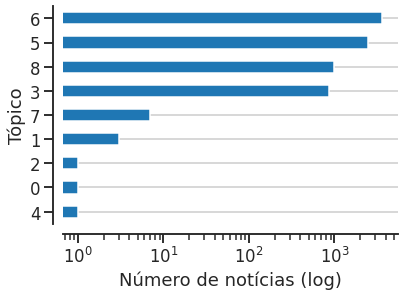

In [ ]:
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

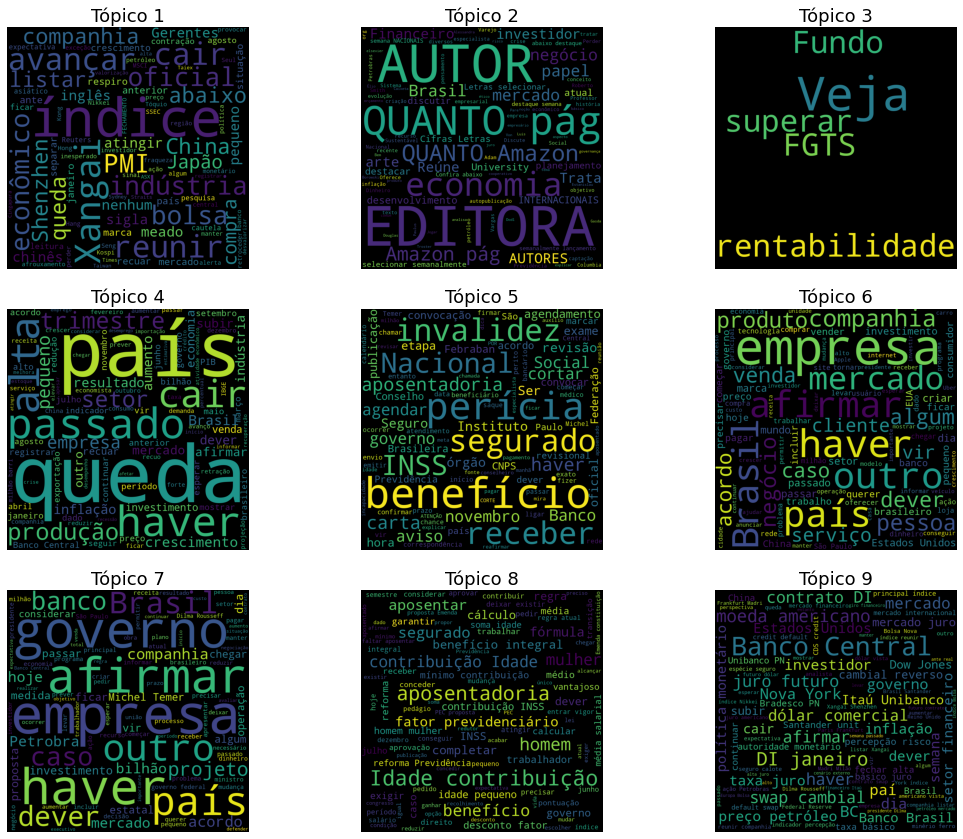

In [ ]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    # Escreva seu código aqui
    wordcloud = WordCloud(height=800, width=800, max_words=100).generate(text)
    ax.imshow(wordcloud)
    ax.axis("off")
    return ax
    
def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

## Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

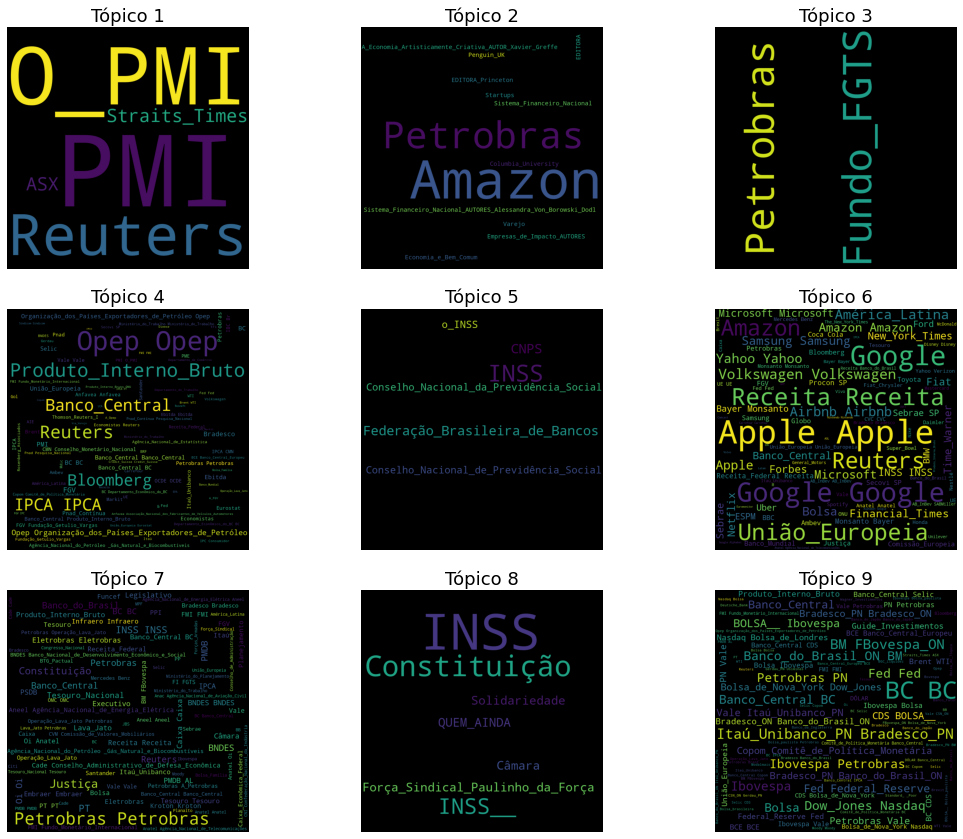

In [ ]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()